In [2]:
import pandas as pd
import numpy as np
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline

# spark = sparknlp.start()

spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","6G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:4.1.0")\
    .getOrCreate()

# parqDF = spark.read.parquet("./tmp/news.parquet")

# parqDF.show()

22/11/01 17:47:19 WARN Utils: Your hostname, zainab-ThinkPad-T560 resolves to a loopback address: 127.0.1.1; using 192.168.178.29 instead (on interface wlp4s0)
22/11/01 17:47:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/zainab/miniconda3/envs/sparknlp/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/zainab/.ivy2/cache
The jars for the packages stored in: /home/zainab/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2924efd9-7d8b-448b-ab16-533f32a6dc21;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.1.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in local-m2-cache
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlom

In [3]:
MODEL_NAME = "tfhub_use"

In [4]:
# To compare the similarity of sentences, enter them as strings in this list.
text_list = [
    "Noor’s father Ambassador (Retd) Shaukat Ali Mukadam was the first one in her family to see her decapitated body.",
    "One year after Noor: Shaukat Mukadam talks about his daughter’s murder trial",
    "Noor’s father approaches court against grant of bail",
    "After filling out this form, you will receive a confirmation email to complete your signup.",
    "It was raining, so I waited beneath the balcony outside the cafe.",
    "I stayed under the deck of the cafe because it was rainy outside.",
    "I like the cafe down the street because it's not too loud in there.",
    "Unimaginable is how they felt when they saw their Noor’s mutilated body.",
    "Web traffic analysis shows that most Internet users browse on mobile nowadays."
]

In [5]:
# Transforms the input text into a document usable by the SparkNLP pipeline.
document_assembler = DocumentAssembler()
document_assembler.setInputCol('text')
document_assembler.setOutputCol('document')

# Separates the text into individual tokens (words and punctuation).
tokenizer = Tokenizer()
tokenizer.setInputCols(['document'])
tokenizer.setOutputCol('token')

# Encodes the text as a single vector representing semantic features.
sentence_encoder = UniversalSentenceEncoder.pretrained(name=MODEL_NAME)
sentence_encoder.setInputCols(['document', 'token'])
sentence_encoder.setOutputCol('sentence_embeddings')

nlp_pipeline = Pipeline(stages=[
    document_assembler, 
    tokenizer,
    sentence_encoder
])

# Fit the model to an empty data frame so it can be used on inputs.
empty_df = spark.createDataFrame([['']]).toDF('text')
pipeline_model = nlp_pipeline.fit(empty_df)
light_pipeline = LightPipeline(pipeline_model)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[ | ]tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[ / ]Download done! Loading the resource.
[ — ]

[ | ]

2022-11-01 17:48:21.998519: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[ \ ]

2022-11-01 17:48:29.423959: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.
2022-11-01 17:48:29.533420: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.
2022-11-01 17:48:29.646137: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.
2022-11-01 17:48:29.809818: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.
2022-11-01 17:48:29.963402: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 60236800 exceeds 10% of free system memory.


[OK!]


In [6]:
def get_similarity(input_list):
    df = spark.createDataFrame(pd.DataFrame({'text': input_list}))
    result = light_pipeline.transform(df)
    embeddings = []
    for r in result.collect():
        embeddings.append(r.sentence_embeddings[0].embeddings)
    embeddings_matrix = np.array(embeddings)
    return np.matmul(embeddings_matrix, embeddings_matrix.transpose())

In [7]:
result = get_similarity(text_list)

In [8]:
np.savetxt(f'oldnews1.csv',
              get_similarity(text_list),
              delimiter=',')

In [25]:
import seaborn as sns

def plot_similarity(input_list):
    g = sns.heatmap(
        get_similarity(input_list),
        xticklabels=input_list,
        yticklabels=input_list,
        vmin=0,
        vmax=1,
        cmap="YlOrRd")
    g.set_xticklabels(input_list, rotation=90)
    g.set_title("Semantic Textual Similarity")

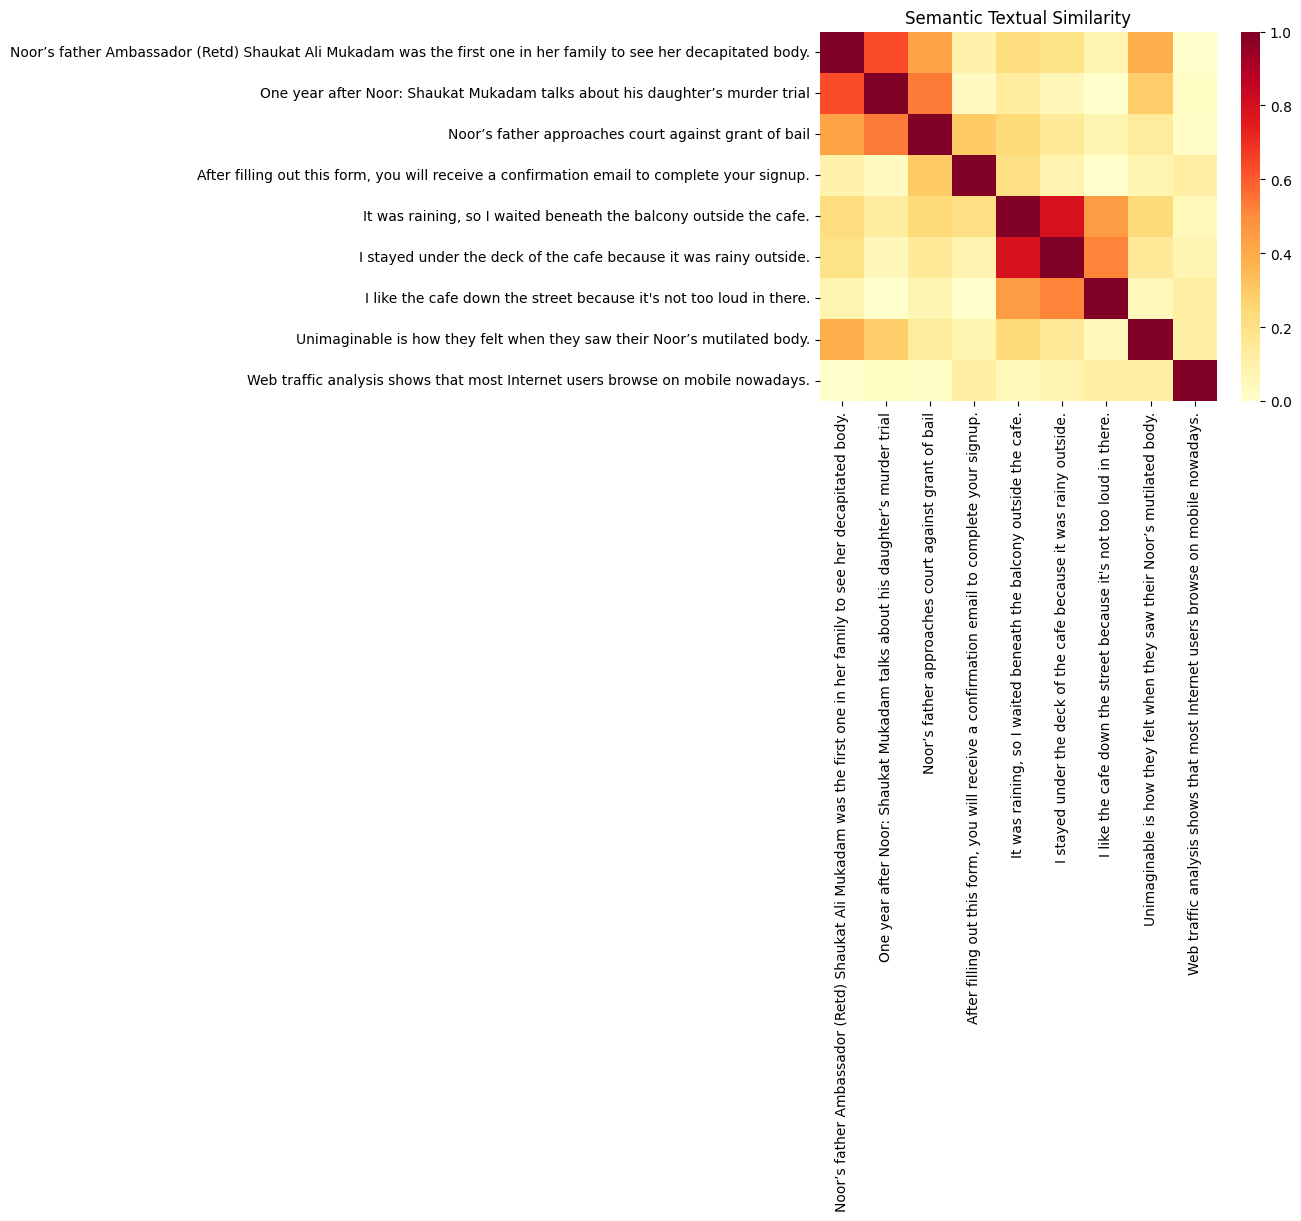

In [26]:
plot_similarity(text_list)

In [9]:
df = spark.createDataFrame(pd.DataFrame({'text': text_list}))
result = light_pipeline.transform(df)
result.printSchema()

root
 |-- text: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- token: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 